# **UrbanPy**
> UrbanPy es un paquete de funciones análiticas que resuelve en forma automatizada todo el flujo de trabajo requerido como obtener fronteras geográficas de una ciudad, estimar población, ubicar sitios de interés, e incluso calcular tiempos de viaje a través del sistema local de calles.

UrbanPy tiene como característica principal la posibilidad de realizar análisis de accesibilidad utilizando únicamente datos abiertos. La herramienta ofrece acceso a diferentes tipos de información, entre los que se encuentran:
- Datos [**OpenStreetMap**](https://www.openstreetmap.org/) (establecimientos, calles, fronteras, etc.)
- Construcción grafos desde OpenStreetMap usando [**OSMnx**](https://github.com/gboeing/osmnx).
- Puntos de interés clasificados por categorías (`food`, `health`, `finance`, `education`)
- Densidad poblacional con una resolución de 30m, usando dataset de [**Data for Good**](https://dataforgood.fb.com/tools/population-density-maps/).
- Archivos disponibles en [**Human Data Exchange**](https://data.humdata.org/), incluyendo archivos georreferenciados.

UrbanPy se encuentra integrado con librerías como [**GeoPandas**](https://geopandas.org/getting_started.html), [**H3**](https://h3geo.org/), [**matplotlib**](https://matplotlib.org/stable/contents.html), [**Plotly**](https://plotly.com/python/) y [**OSMnx**](https://osmnx.readthedocs.io/en/stable/index.html). Esto permite utilizar facilemente los resultados del análisis como insumo para otras tareas en Python o exportarlos a un software de SIG.

Para obtener información adicional visitar la [**documentación**](https://el-bid.github.io/urbanpy) y la [página web]((https://code.iadb.org/es/herramientas/urbanpy) del Banco Interamericano de Desarrollo (desarrollador de la herramienta).

## **1.** Importar librerías

In [26]:
import urbanpy as up
import geopandas as gpd
import osmnx as ox # eliminar si no ha installado OSMnx
import warnings
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")

## **2.** Descargar y preprocesar información
### **2.1.** Límites del areá de interés
Para descargar la infomación con los límites de las fronteras de un municipio es suficiente con llamar la función `up,download.nominatim_osm("ciudad")`.  Si la entidad que muestra el gráfico no corresponde a la esperada, se puede pasar el argumento `expected_position` lo que indica el índice del polígono dado el caso que para el lugar elegido, dado el caso de que se descarguen varios polígonos.

<AxesSubplot:>

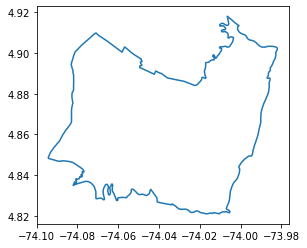

In [2]:
# Descargar GeoDataframe desde OpenStreetMaps
city = 'Chía, Colombia'
city_bdry = up.download.nominatim_osm(city) # Límites administrativos
city_bdry.boundary.plot()

### **2.2.** Descargar mapa densidad poblacional
La iniciativa **Data for Good** de Facebook ofrece un mapa de alta resolución (30m) con una estimación de la población con cobertura global. Estos mapas se derivan de un modelo de inteligencia artifical que integran datos de censos e imágenes satelites. Esta información esta disponible para su descarga en la página de Humanitaria Data Exchange [(**HDX**)](https://data.humdata.org/dataset/colombia-high-resolution-population-density-maps-demographic-estimates). 

La función `up.download.hdx_fb_population("país", "tipo")`  de UrbanPy descarga el dataset y construye un objeto de tipo **GeoDataFrame**. El segundo argumento puede tomar los siguientes valores: `"full"`, `"children"`, `"youth"`, `"elderly"`; indicando el segmento de la población deseado.

> Esta celda es la que más consume tiempo, ya que descarga información de toda Colombia. Sin embargo, solo es necesario ejecutarla una vez.

In [3]:
# Datos población alta resolución ofrecidos por facebook
pop_col = up.download.hdx_fb_population('colombia', 'full')

Para obtener datos del areá de estudio se utiliza la función `up.geom.filter_population()`, la cual hace un recorte con la extensión del polígono específicado. Luego se aplica la función `gpd.clip()` para conservar solos las entidades que contenga el polígono de límites. Se pueden pasar argumentos adicionales al método `.plot()` con la misma sintasix que **matplotlib**.

<AxesSubplot:>

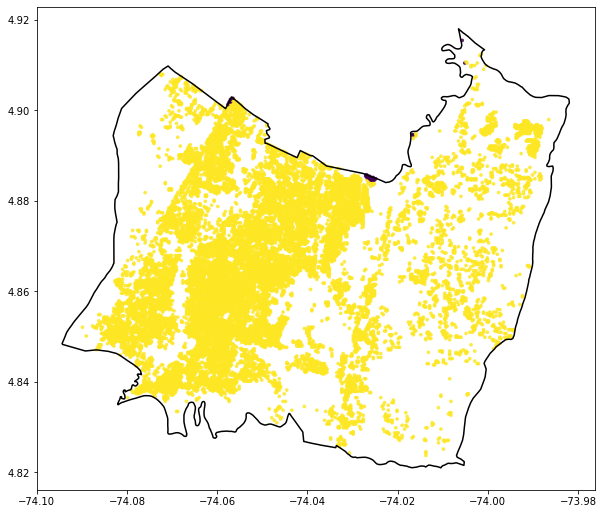

In [4]:
# Recorta datos de población con la extensión de límite administrativo
pop_col_clip = up.geom.filter_population(pop_col, city_bdry) 

# Este paso se puede eliminar si se desea tener información de la extensión total
# del rectacgulo que contiene el areá de interés
pop_city = gpd.clip(pop_col_clip, city_bdry) 

# Mostrar limites ciudad
base = city_bdry.boundary.plot(figsize=(10,10), color='k') # Mostrar limites ciudad
pop_city.plot(ax=base, column="population_2020", markersize=7, alpha=0.8) # Añadir densidad

## **2.3.** Integrar información a hexágonos **H3**

**Hexagonal Hierarchical Spatial Index [(H3)](https://h3geo.org/)** es una librería desarrollada por **Uber** que implementa una rejilla hexagonal para que facilitar la visualización y exploración eficiente de datos espaciales. Gracias a esta librería se pueden agrupar entidades que en hexágonos y procesar bases de datos extensas rápidamente.

Desde UrbanPy se pueden crear hexágonos con función `gen_hexagons(H3_resolution, boundary)` que construirá un **GeoDataFrame** con los hexágono. El primer argumento corresponde a la resolución de la rejilla de acuerdo con los valores presentados [**aquí**](https://h3geo.org/docs/core-library/restable). Ya que la resolución de densidad poblacional es de 30m, se recomienda usar una resolución menor o igual a `10`.

> La **resolución** es inversamente proporcional al **número** de hexágonos que serán creados.

<AxesSubplot:>

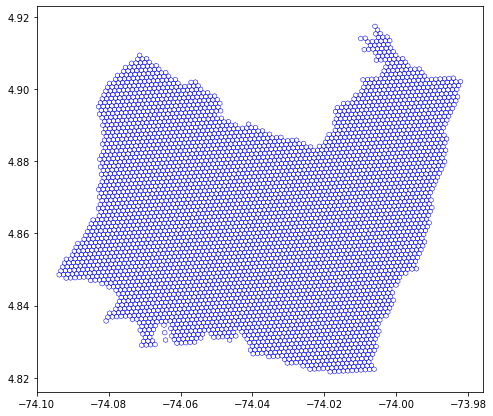

In [5]:
resolution = 10
hex_city = up.geom.gen_hexagons(resolution, city_bdry)
hex_city.boundary.plot(figsize=(8,8), color='b', linewidth=0.5)

El siguiente paso en asignar la información la información de población a cada hexágono, con la función `up.geom.merge_shape_hex()`, se le deben pasar como argumentos el objeto con los hexágonos creado anteriormente y una base de datos georreferenciada **(GeoDataFrame)**, ademas de un diccionario con los atributos a agregar y el tipo de unión a realizar, por ejemplo el siguiente diccionario: 

`agg = {"population_2020": "sum",
"population_2018": "min"}`
.

indica que para el atributo `population_2020` se calcula la sumatoria por cada hexágono, mientras que para `population_2018` se toma el valor mínimo.
> El mapa de densidad poblacional **no** asigna a cada pixel su valor estimado de población. Para obtener la población se suman los valores de los puntos que se encuentren dentro de una areá determinada.

<AxesSubplot:>

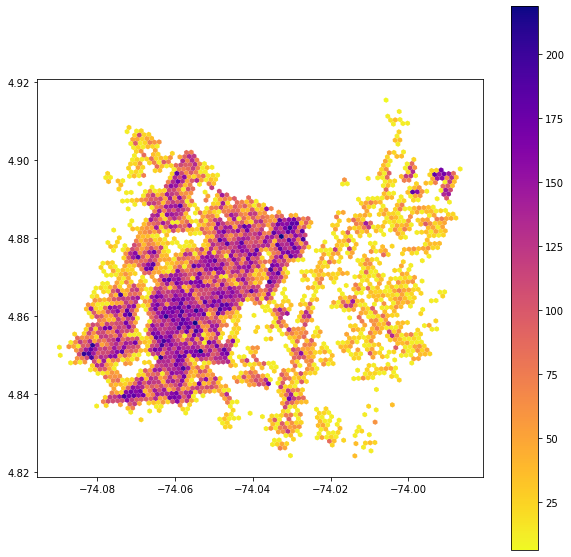

In [6]:
#Asigna información base de datos a entidades espaciales
pop_hex = up.geom.merge_shape_hex(hex_city, pop_city, agg={'population_2020':'sum'})

#Visualizar el mapa
pop_hex.plot(figsize=(10,10), column="population_2020", cmap="plasma_r", legend=True)

## **3.** Determinar distancia desde cada hexágono hasta el establecimiento más cercano de una categoría específica
### **3.1.** Descargar sitios de interés
UrbanPy permite descargar información desde [**OpenStreetMap**](https://www.openstreetmap.org) de manera muy sencilla, sin necesidad de realizar consultas complicadas mediante una [API](https://wiki.openstreetmap.org/wiki/Databases_and_data_access_APIs). La función `download.overpass_pois()` descarga sitios de interés clasificado en las categorías: `"health"`, `"food"`, `"finance"`, `"education"` ubicados dentro de un polígono especifico, en este caso `city_dry` descargado en la sección *2.1*. 

Debido a que los OpenStreetMap no tiene mapeado algunos sitios, puede ser necesario importar un archivo `.shp`con los puntos de interés y construir  un **GeoDataFrame**, esta operación se puede realizar usando los siguientes comandos:

```
filename = "establecimientos.shp" # Ruta archivo con ubicación de establecimientos
file = open(filename)
sitios = geopandas.read_file(file)
```

16

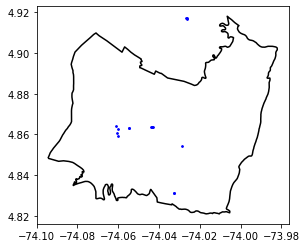

In [7]:
category = "finance"

# Reemplazar con el código para carga .shp
sitios = up.download.overpass_pois(bounds=city_bdry.total_bounds, facilities=category) 

# Graficar establecimientos y límites
base = city_bdry.boundary.plot(color='k')
sitios.plot(ax=base, markersize=3, color='b')
sitios.shape[0] # Muestra número establecimientos descargados

### **3.2.** Determinar distancia hasta cada el establecimiento más cercano
La función `up.utils.nn_search` encuentra la distancia e índice del establecimiento más cercano a cada hexágono, esta búsqueda considera únicamente la distancia entre los dos puntos (**NO** tiene en cuenta la red vial). El resultado se encuentra en grados, por lo que se debe convertir a metros.

<AxesSubplot:>

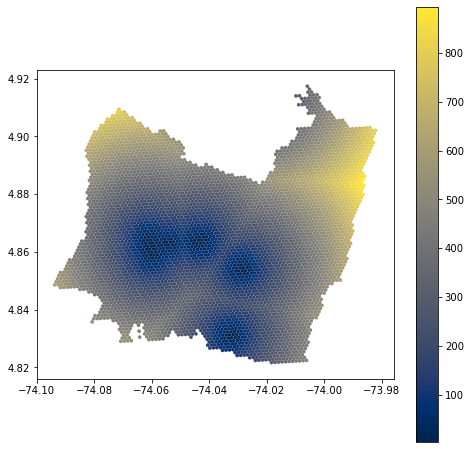

In [9]:
# Calcular centroide
pop_hex['lat'] = pop_hex.geometry.centroid.y
pop_hex['lon'] = pop_hex.geometry.centroid.x

# Determinar distancia 
pop_hex["dist_closest_est"], _ = up.utils.nn_search(
    tree_features = sitios[['lat', 'lon']].values, # Establecimientos
    query_features = pop_hex[['lat', 'lon']].values, # Centroide hexágonos
    metric="haversine"
)

#Convertir distancia a metros
earth_radius = 6371 # km
pop_hex["dist_closest_est"] = pop_hex["dist_closest_est"]/earth_radius*1000**2

# Graficar distancia establecimiento más cercano
pop_hex.plot(figsize=(8,8), column="dist_closest_est", cmap="cividis", legend=True)

### **3.3.** Ponderar respecto a la población
Asumiendo que los hexágonos mas poblados tienen una mayor importancia, se calcula una atributo que indique las ubicaciones más aisladas. Gracias a que las objeto que almacena los hexágonos es del tipo **GeoDataFrame** se pueden realizar operaciones entre atributos como si fuesen arreglos. El resultado es una mapa normalizado del producto de `population_2020` y `dist_closest_est`.

<AxesSubplot:>

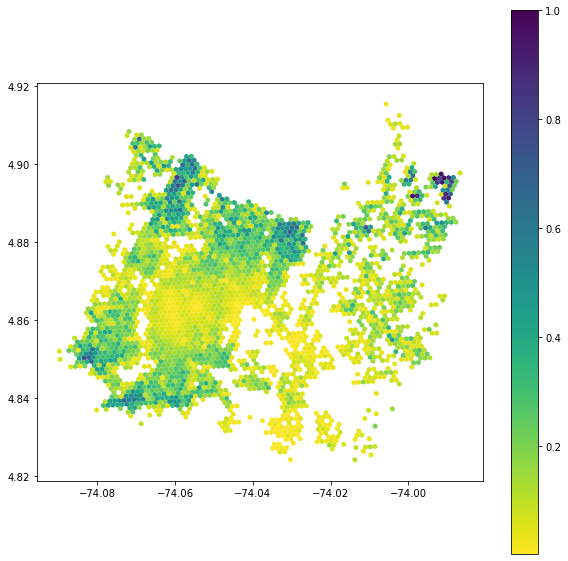

In [24]:
# Calcular el producto entre distacia y población
pop_hex["dist_pond"] = pop_hex["dist_closest_est"]*pop_hex["population_2020"]

# Dividir por el máximo (normalizar)
pop_hex["dist_pond"] =pop_hex["dist_pond"] / max(pop_hex["dist_pond"].dropna())

# Graficar
pop_hex.plot(column="dist_pond", figsize=(10,10), legend=True, cmap="viridis_r")


### **3.4.** Exportar resultados a shapefile
GeoPandas permite exportar a diferentes formatos gracias a la librería [**GDAL**](https://gdal.org). Los formatos soportados por **GDAL** se encuentran [aquí](https://gdal.org/drivers/vector/index.html). El método `.to_file("nombre.shp")` crear un archivo en la carpeta de trabajo.
> Para exportar a otros formatos pasar como segundo argumento el nombre del driver (columna "Short name", de la tabla mencionada anteriormente)

In [25]:
pop_hex.to_file("chía_hex.shp")

## **4.** Graficar incluyendo red vial
Se puede añadir un grado descargado con OSMnx que contenga las calles para facilitar la compresion de los resultados.
>**Ejecutar la siguiente celda si OSMnx se encuentra instalado**

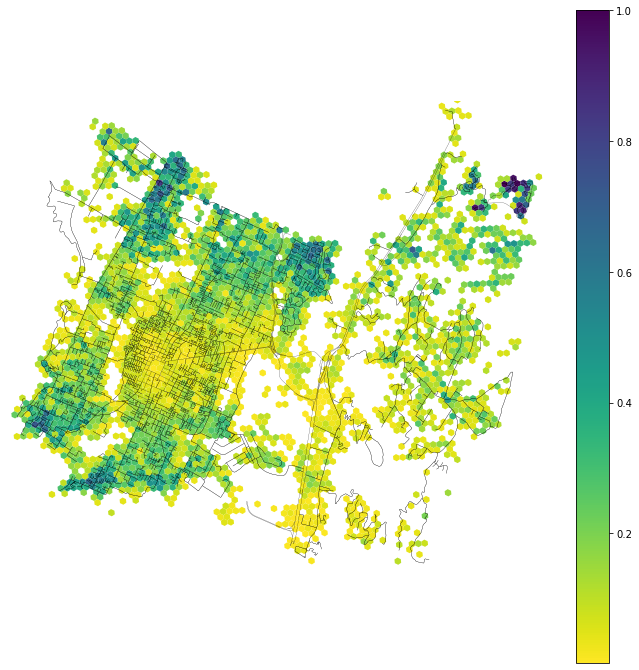

In [54]:
G = ox.graph_from_place(city, network_type="drive") # Descargar grafo

fig, ax = ox.plot_graph(G, figsize=(12,12),edge_color='black', edge_linewidth=0.2, bgcolor='white',
                        node_size=0, show=False, close=False)
pop_hex.plot(ax=ax, column="dist_pond", cmap="viridis_r", zorder=0, legend=True)
plt.show()